# ResNet101

In [1]:
import os
# Root of data. Change this to match your directory structure. 
# datadir should contain train/ val/ and test/

data_dir = "images"
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import torch.nn.functional as F
# You might not have tqdm, which gives you nice progress bars
!pip install tqdm
from tqdm import tqdm
# import optimizer library
from torch.optim.lr_scheduler import StepLR

import os
import copy

# display image
!pip install -U image
import PIL.Image
from io import BytesIO
from IPython.display import clear_output, Image, display

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only")


PyTorch Version:  1.8.1+cpu
Torchvision Version:  0.9.1+cpu


In [3]:
def initialize_model(model_name, num_classes, resume_from = None):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    # The model (nn.Module) to return
    model_ft = None
    # The input image is expected to be (input_size, input_size)
    input_size = 0
    
    # You may NOT use pretrained models!! 
    use_pretrained = False
    
    # By default, all parameters will be trained (useful when you're starting from scratch)
    # Within this function you can set .requires_grad = False for various parameters, if you
    # don't want to learn them

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(num_ftrs, num_classes)
        )
        input_size = 224
    
    elif model_name == "resnet50":
        """ Resnet50
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(num_ftrs, num_classes)
        )
        input_size = 224  
        
    elif model_name == "resnet101":
        """ Resnet101
        """
        model_ft = models.resnet101(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224    

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    else:
        raise Exception("Invalid model name!")
    
    if resume_from is not None:
        print("Loading weights from %s" % resume_from)
        model_ft.load_state_dict(torch.load(resume_from))
    
    return model_ft, input_size

In [4]:
def get_dataloaders(input_size, batch_size, shuffle = True):
    # How to transform the image when you are loading them.
    # you'll likely want to mess with the transforms on the training set.
    
    # For now, we resize/crop the image to the correct input size for our network,
    # then convert it to a [C,H,W] tensor, then normalize it to values with a given mean/stdev. These normalization constants
    # are derived from aggregating lots of data and happen to produce better results.
    
    # add random rotation to data augmentation
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomRotation(25),
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.RandomRotation(25),
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.RandomRotation(25),
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    }
    # Create training and validation datasets
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in data_transforms.keys()}
    # Create training and validation dataloaders
    # Never shuffle the test set
    class_names = image_datasets['train'].classes
    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=False if x != 'train' else shuffle, num_workers=4) for x in data_transforms.keys()}
    return dataloaders_dict, class_names

In [5]:
def train_model(model, dataloaders, criterion, optimizer, save_dir = None, save_all_epochs=False, num_epochs=25):
    '''
    model: The NN to train
    dataloaders: A dictionary containing at least the keys 
                 'train','val' that maps to Pytorch data loaders for the dataset
    criterion: The Loss function
    optimizer: The algorithm to update weights 
               (Variations on gradient descent)
    num_epochs: How many epochs to train for
    save_dir: Where to save the best model weights that are found, 
              as they are found. Will save to save_dir/weights_best.pt
              Using None will not write anything to disk
    save_all_epochs: Whether to save weights for ALL epochs, not just the best
                     validation error epoch. Will save to save_dir/weights_e{#}.pt
    '''
    since = time.time()
    
    train_losses, val_losses = [], []
    train_acc, val_acc = [], []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            # TQDM has nice progress bars
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # torch.max outputs the maximum value, and its index
                    # Since the input is batched, we take the max along axis 1
                    # (the meaningful outputs)
                    _, preds = torch.max(outputs, 1)

                    # backprop + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            # scheduler step
#             scheduler.step()
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_losses.append(epoch_loss)
                val_acc.append(epoch_acc)
            if phase == "train":
                train_losses.append(epoch_loss)
                train_acc.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, train_acc, val_losses, val_acc

In [6]:
def make_optimizer(model):
    # Get all the parameters
    params_to_update = model.parameters()
    print("Params to learn:")
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

    # Use SGD
    #optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
    optimizer = optim.Adam(params_to_update, lr=0.001)
    return optimizer

def get_loss():
    # Create an instance of the loss function
    criterion = nn.CrossEntropyLoss()
    return criterion

In [7]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet]
# You can add your own, or modify these however you wish!
model_name = "resnet101"

# Number of classes in the dataset
# Abnormal,Benign,Normal
num_classes = 3

# Batch size for training (change depending on how much memory you have)
# You should use a power of 2.
batch_size = 16

# Shuffle the input data?
shuffle_datasets = True

# Number of epochs to train for 
num_epochs = 50

### IO
# Path to a model file to use to start weights at
resume_from = None

# Directory to save weights to
save_dir = "weights"
os.makedirs(save_dir, exist_ok=True)

# Save weights for all epochs, not just the best one
save_all_epochs = True


# data dir
data_dir = "images"

In [8]:
# Initialize the model
model, input_size = initialize_model(model_name = model_name, num_classes = num_classes, resume_from = resume_from)
# get dataloaders
dataloaders, class_name = get_dataloaders(input_size, batch_size, shuffle_datasets)
# loss function
criterion = get_loss()

In [9]:
# Only run this module and the next if the code is being run for the first time, else only run till the previous module
# Move the model to the gpu if needed
model = model.to(device)

optimizer = make_optimizer(model)
# scheduler for optimizing
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.0.conv3.weight
	 layer1.0.bn3.weight
	 layer1.0.bn3.bias
	 layer1.0.downsample.0.weight
	 layer1.0.downsample.1.weight
	 layer1.0.downsample.1.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.1.conv3.weight
	 layer1.1.bn3.weight
	 layer1.1.bn3.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer1.2.conv3.weight
	 layer1.2.bn3.weight
	 layer1.2.bn3.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.conv3.weight
	 layer2.0.bn3.weight
	 layer2.0.bn3.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight

## Training the Model

In [10]:
# Train the model!
trained_model, train_losses, train_acc, val_losses, val_acc = train_model(model=model, dataloaders=dataloaders, criterion=criterion, optimizer=optimizer,
           save_dir=save_dir, save_all_epochs=save_all_epochs, num_epochs=num_epochs)

  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

Epoch 0/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.7512 Acc: 0.7529


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.5007 Acc: 0.8821

Epoch 1/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.5434 Acc: 0.8191


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.3717 Acc: 0.9083

Epoch 2/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.4965 Acc: 0.8197


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.3824 Acc: 0.8646

Epoch 3/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.4600 Acc: 0.8343


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.6783 Acc: 0.8734

Epoch 4/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.3940 Acc: 0.8631


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.2791 Acc: 0.8908

Epoch 5/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.3933 Acc: 0.8642


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.3232 Acc: 0.8996

Epoch 6/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.4970 Acc: 0.8235


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.3833 Acc: 0.8777

Epoch 7/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.5949 Acc: 0.7844


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.3700 Acc: 0.8821

Epoch 8/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.4490 Acc: 0.8495


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.2830 Acc: 0.9127

Epoch 9/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.3884 Acc: 0.8571


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.2626 Acc: 0.9214

Epoch 10/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.3353 Acc: 0.8827


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.2064 Acc: 0.9432

Epoch 11/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.3585 Acc: 0.8724


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.2340 Acc: 0.9258

Epoch 12/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.3818 Acc: 0.8588


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.2419 Acc: 0.9083

Epoch 13/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.3116 Acc: 0.8952


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1978 Acc: 0.9389

Epoch 14/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.3490 Acc: 0.8767


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1818 Acc: 0.9432

Epoch 15/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.3566 Acc: 0.8696


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.2040 Acc: 0.9083

Epoch 16/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.2847 Acc: 0.8973


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1726 Acc: 0.9345

Epoch 17/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.2790 Acc: 0.9022


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.2005 Acc: 0.9345

Epoch 18/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.3072 Acc: 0.8924


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.2357 Acc: 0.8996

Epoch 19/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.2961 Acc: 0.8919


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1733 Acc: 0.9345

Epoch 20/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.2404 Acc: 0.9125


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.2367 Acc: 0.9258

Epoch 21/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.2650 Acc: 0.9066


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:43<00:00,  2.90s/it]


val Loss: 0.1830 Acc: 0.9607


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]


Epoch 22/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.2637 Acc: 0.9022


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.2215 Acc: 0.9345

Epoch 23/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.3125 Acc: 0.8914


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.2709 Acc: 0.9432

Epoch 24/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.2616 Acc: 0.9066


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1637 Acc: 0.9563

Epoch 25/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.2872 Acc: 0.8979


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.5953 Acc: 0.8865

Epoch 26/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.5574 Acc: 0.8066


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.2950 Acc: 0.8952

Epoch 27/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.4029 Acc: 0.8577


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.2023 Acc: 0.9345

Epoch 28/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.3616 Acc: 0.8620


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.3898 Acc: 0.8472

Epoch 29/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.3583 Acc: 0.8838


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1730 Acc: 0.9214

Epoch 30/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.3140 Acc: 0.8881


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1779 Acc: 0.9389

Epoch 31/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.3289 Acc: 0.8897


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1795 Acc: 0.9432

Epoch 32/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.2995 Acc: 0.8897


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1524 Acc: 0.9345

Epoch 33/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.2598 Acc: 0.9104


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 1.4362 Acc: 0.7336

Epoch 34/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.2804 Acc: 0.9039


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1810 Acc: 0.9258

Epoch 35/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.2637 Acc: 0.9098


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1567 Acc: 0.9520

Epoch 36/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.2379 Acc: 0.9169


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1287 Acc: 0.9563

Epoch 37/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.2415 Acc: 0.9136


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1696 Acc: 0.9563

Epoch 38/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.2861 Acc: 0.9033


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1707 Acc: 0.9520

Epoch 39/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.2540 Acc: 0.9136


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1567 Acc: 0.9520

Epoch 40/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.2445 Acc: 0.9109


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1382 Acc: 0.9476

Epoch 41/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.2310 Acc: 0.9142


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1856 Acc: 0.9214

Epoch 42/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.4672 Acc: 0.8262


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.2812 Acc: 0.9170

Epoch 43/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.3432 Acc: 0.8821


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.2795 Acc: 0.9301

Epoch 44/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.5115 Acc: 0.8126


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.3177 Acc: 0.9083

Epoch 45/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.3633 Acc: 0.8647


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.2865 Acc: 0.8996

Epoch 46/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.3355 Acc: 0.8685


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.2779 Acc: 0.9039

Epoch 47/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.3433 Acc: 0.8848


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1567 Acc: 0.9389

Epoch 48/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.2845 Acc: 0.9082


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1789 Acc: 0.9301

Epoch 49/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.2710 Acc: 0.9044


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:45<00:00,  3.03s/it]

val Loss: 0.1783 Acc: 0.9214

Training complete in 952m 59s
Best val Acc: 0.960699


### Saving Model 

In [12]:
# save pretrained weights
torch.save(trained_model.state_dict(), "weights/resnet101")

## Plotting Losses and Accuracy

In [13]:
# x label for training 50 to 100 epoch
x = np.arange(0,50,1)

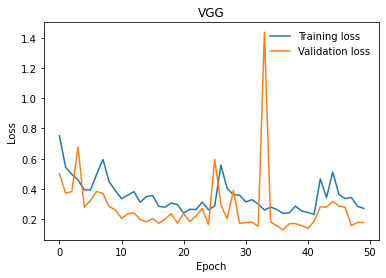

In [14]:
plt.plot(x, train_losses, label='Training loss')
plt.plot(x, val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.title("VGG")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

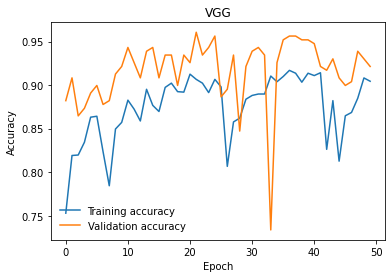

In [15]:
plt.plot(x, train_acc, label='Training accuracy')
plt.plot(x, val_acc, label='Validation accuracy')
plt.legend(frameon=False)
plt.title("VGG")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [16]:
def evaluate(model, dataloader, criterion, is_labelled = False, generate_labels = True, k = 3):
    # If is_labelled, we want to compute loss, top-1 accuracy and top-5 accuracy
    # If generate_labels, we want to output the actual labels
    # Set the model to evaluate mode
    model.eval()
    running_loss = 0
    running_top1_correct = 0
    running_top5_correct = 0
    predicted_labels = []
    

    # Iterate over data.
    # TQDM has nice progress bars
    for inputs, labels in tqdm(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        tiled_labels = torch.stack([labels.data for i in range(k)], dim=1) 
        # Makes this to calculate "top 5 prediction is correct"
        # [[label1 label1 label1 label1 label1], [label2 label2 label2 label label2]]

        # forward
        # track history if only in train
        with torch.set_grad_enabled(False):
            # Get model outputs and calculate loss
            outputs = model(inputs)
            if is_labelled:
                loss = criterion(outputs, labels)

            # torch.topk outputs the maximum values, and their indices
            # Since the input is batched, we take the max along axis 1
            # (the meaningful outputs)
            _, preds = torch.topk(outputs, k=3, dim=1)
            if generate_labels:
                # We want to store these results
                nparr = preds.cpu().detach().numpy()
                predicted_labels.extend([list(nparr[i]) for i in range(len(nparr))])

        if is_labelled:
            # statistics
            running_loss += loss.item() * inputs.size(0)
            # Check only the first prediction
            running_top1_correct += torch.sum(preds[:, 0] == labels.data)
            # Check all 5 predictions
            running_top5_correct += torch.sum(preds == tiled_labels)
        else:
            pass

    # Only compute loss & accuracy if we have the labels
    if is_labelled:
        epoch_loss = float(running_loss / len(dataloader.dataset))
        epoch_top1_acc = float(running_top1_correct.double() / len(dataloader.dataset))
        epoch_top5_acc = float(running_top5_correct.double() / len(dataloader.dataset))
    else:
        epoch_loss = None
        epoch_top1_acc = None
        epoch_top5_acc = None
    
    # Return everything
    return epoch_loss, epoch_top1_acc, epoch_top5_acc, predicted_labels

In [17]:
# set data dir to full image
# data_dir = "full_image"
# set data dir to crop image
data_dir = "images"
# get full image data as testing data
dataloaders, class_name = get_dataloaders(input_size, batch_size, True)

In [18]:
# Get data on the validation set
# Setting this to false will be a little bit faster
generate_validation_labels = True
val_loss, val_top1, val_top5, val_labels = evaluate(model, dataloaders['val'], criterion, is_labelled = True, generate_labels = generate_validation_labels, k = 3)

# Get predictions for the test set
epoch_loss, top1_acc, top5_acc, test_labels = evaluate(model, dataloaders['test'], criterion, is_labelled = True, generate_labels = True, k = 3)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:43<00:00,  2.90s/it]


In [19]:
top1_acc

0.9484978540772532

In [20]:
# data directory of cropped images
data_dir = "images"
class_names = ['normal',
            'abnormal',
            'tumor']

In [21]:
# initialize confusion matrix
confusion_matrix = {x: [0,0,0] for x in class_name}

In [22]:
# load cropped images 
input_size = 224
train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(data_dir,
                         transforms.Compose([
                             transforms.Resize(input_size),
                             transforms.CenterCrop(input_size),
                             transforms.ToTensor(),
                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                         ])),
    batch_size = 1,
    shuffle = False)

In [23]:
# move model to GPU
model = model.to(device)
running_top1_correct = 0
# generate confusion matrix on test data
loader = dataloaders['test']
# generate confusion matrix on all cropped data
# loader = train_loader
for inputs, labels in tqdm(loader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    # predict output
    outputs = model(inputs)
    _, preds = torch.topk(outputs, k=1, dim=1)
    # generate confusion matrix
    for i in range(len(labels)):
        original_label = int(labels[i])
        confusion_matrix[class_names[original_label]][int(preds[i])] += 1
        
    running_top1_correct += torch.sum(preds[:, 0] == labels.data)

epoch_top1_acc = float(running_top1_correct.double() / len(loader.dataset))

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:45<00:00,  3.04s/it]


In [24]:
print(confusion_matrix)
# total accuracy
print(epoch_top1_acc)

{'abnormal': [3, 67, 6], 'normal': [95, 2, 0], 'tumor': [1, 1, 58]}
0.944206008583691


In [25]:
percentage = {x: [y /sum(confusion_matrix[x]) for y in confusion_matrix[x]] for x in confusion_matrix.keys()}
percentage

{'abnormal': [0.039473684210526314, 0.881578947368421, 0.07894736842105263],
 'normal': [0.979381443298969, 0.020618556701030927, 0.0],
 'tumor': [0.016666666666666666, 0.016666666666666666, 0.9666666666666667]}

In [26]:
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

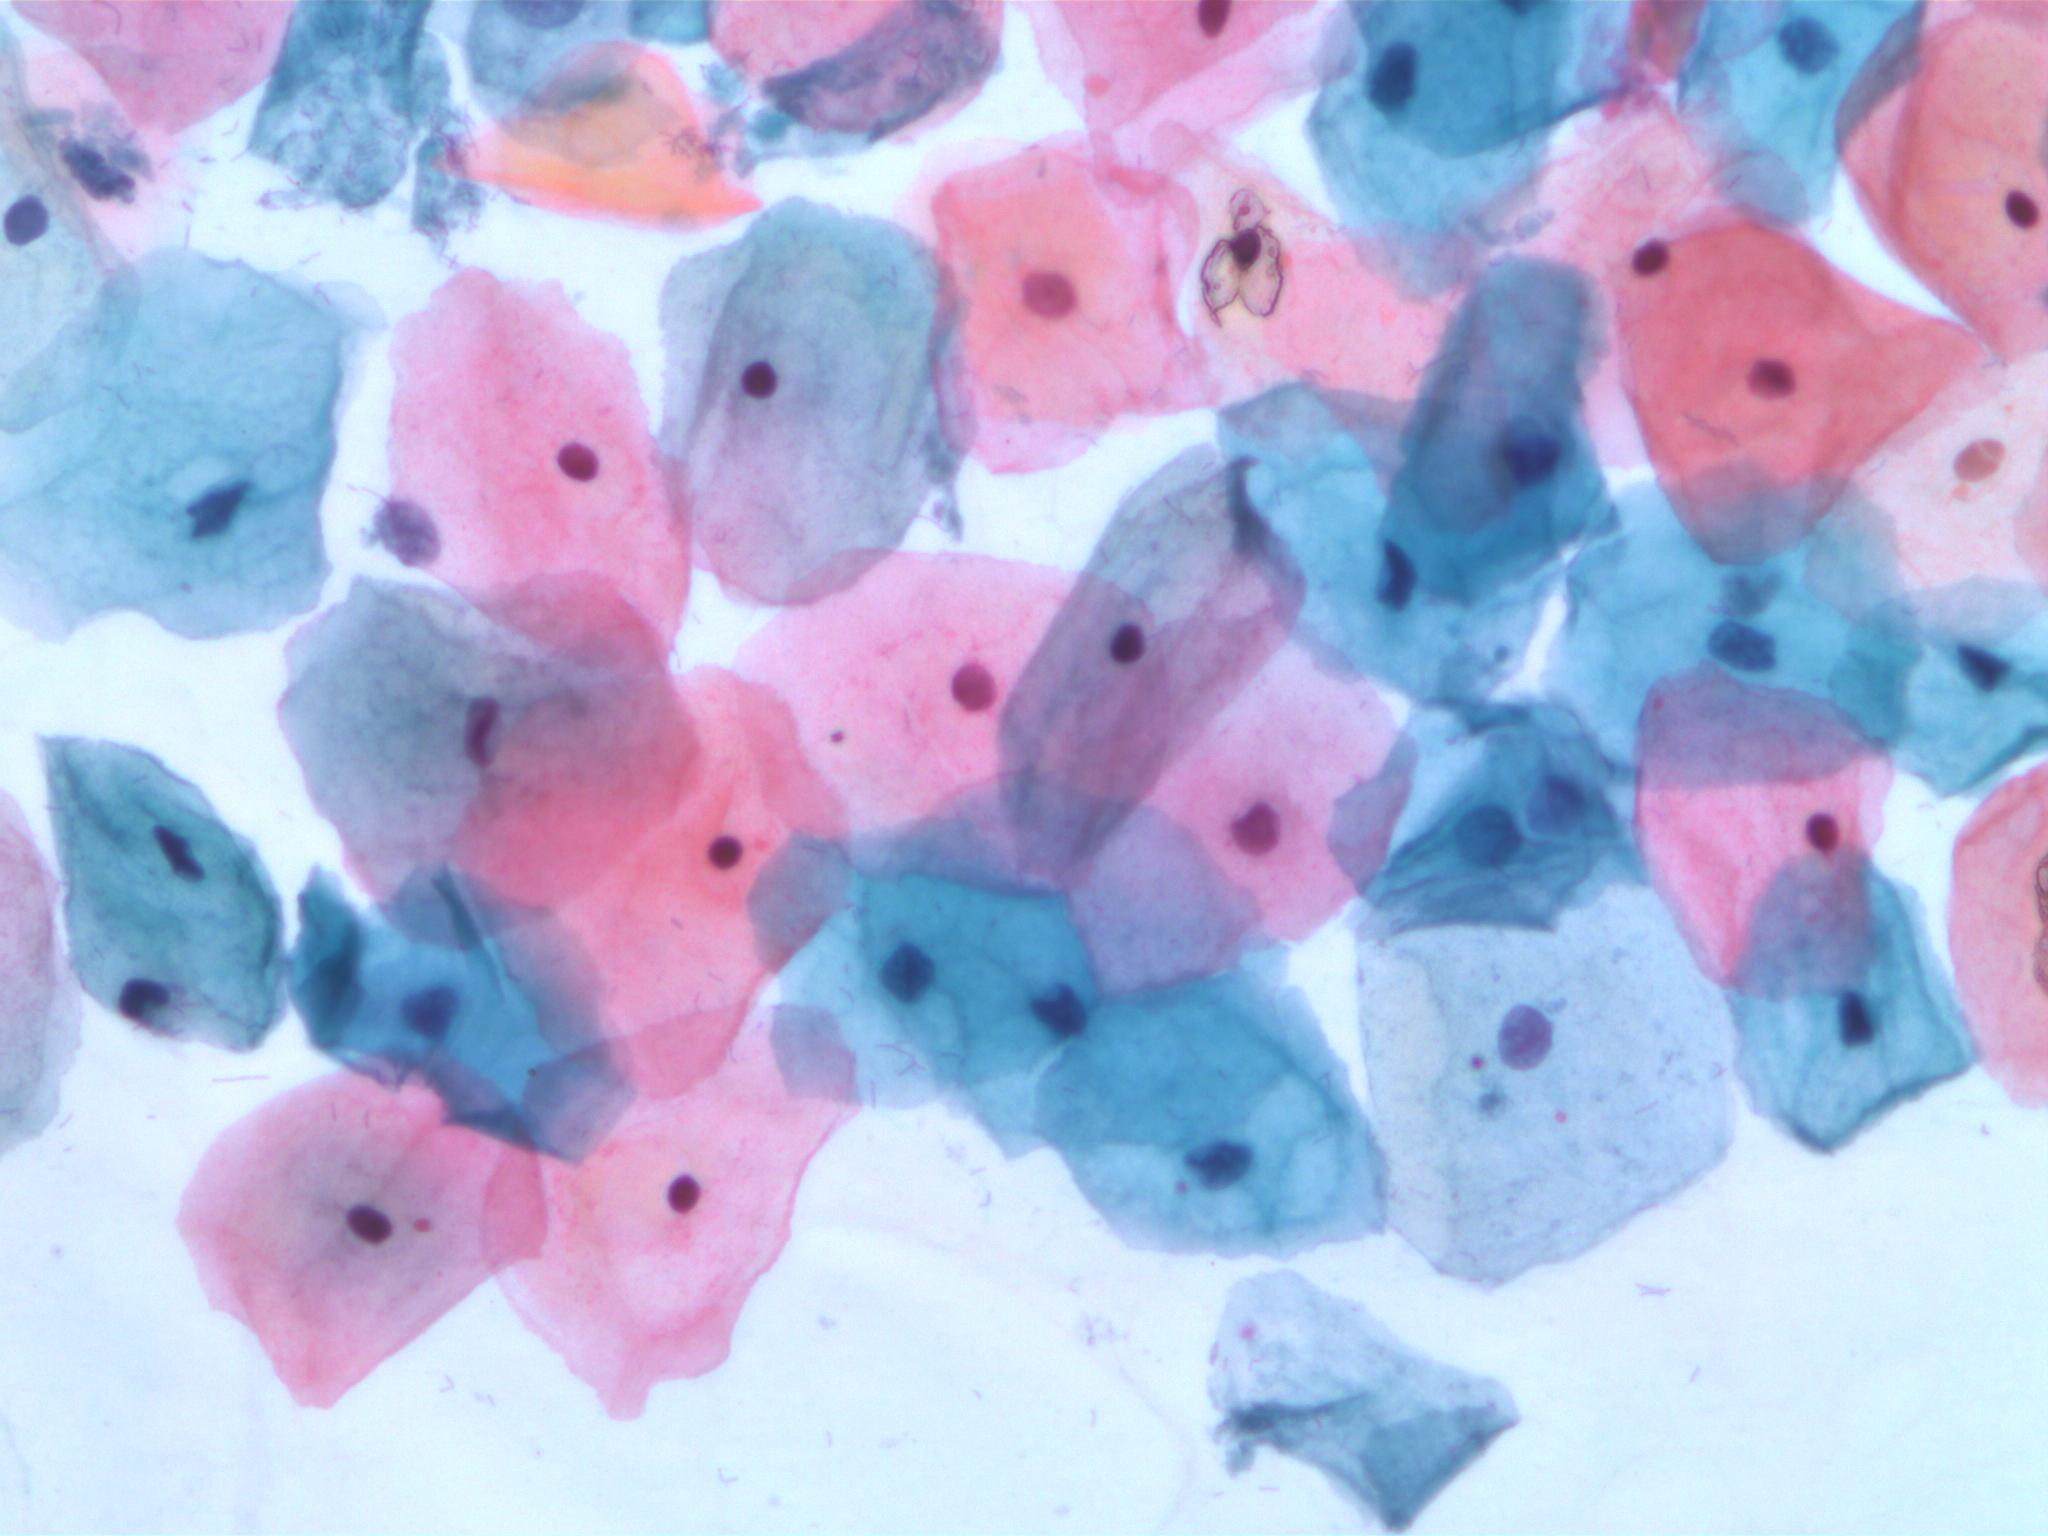

In [32]:
# view full image
img0 = PIL.Image.open('original_images/normal/71.bmp').convert('RGB')
img_numpy = np.array(img0)
showarray(img_numpy)

In [33]:
# shape of full image
img_numpy.shape

(1536, 2048, 3)

torch.Size([3, 256, 256])


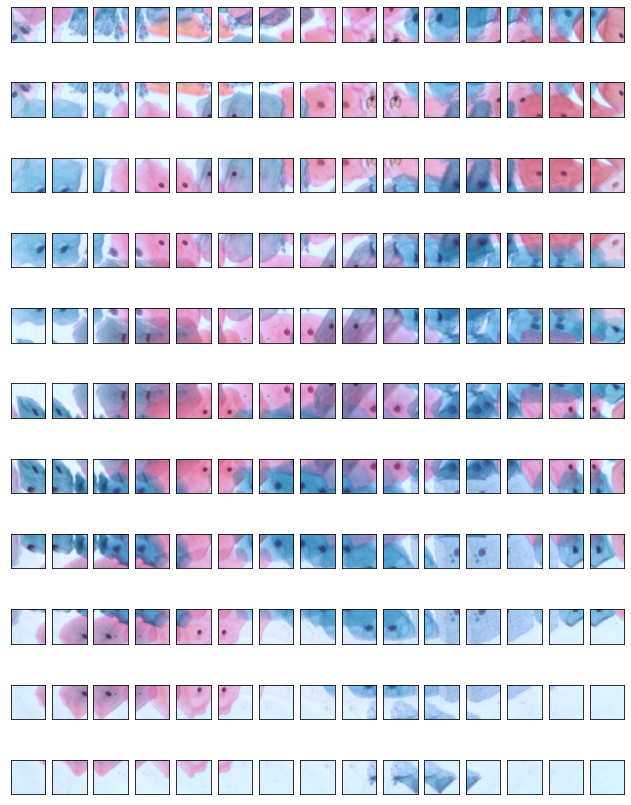

In [34]:
# patches = x.unfold(dim, size, stride).unfold(dim, size, stride).unfold(dim, size, stride)
transt = transforms.ToTensor()
transp = transforms.ToPILImage()
img_t = transt(PIL.Image.open('original_images/normal/71.bmp'))

#torch.Tensor.unfold(dimension, size, step)
#slices the images into 8*8 size patches
size = 256
stride = 128
# first color channel dimension, include all three
# width and height dimension find the common factor of the two for size and stride
patches = img_t.data.unfold(0, 3, 3).unfold(1, size, stride).unfold(2, size, stride)
print(patches[0][0][0].shape)

def visualize(patches):
    """Imshow for Tensor."""   
    # number of slices on height
    slice_h = patches.shape[1]
    slice_w = patches.shape[2]
    fig = plt.figure(figsize=(slice_h, slice_w))
    for i in range(patches.shape[1]):
        for j in range(patches.shape[2]):
            inp = transp(patches[0][i][j])
            inp = np.array(inp)
            ax = fig.add_subplot(slice_h, slice_w, ((i*slice_w)+j)+1, xticks=[], yticks=[])
            plt.imshow(inp)

visualize(patches)

In [35]:
patches.shape

torch.Size([1, 11, 15, 3, 256, 256])

normal: 0.982494056224823


<ipython-input-36-f831a2a9d8d5>:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = sm(prob)


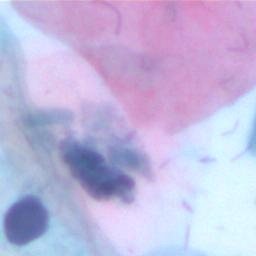

normal: 0.9980962872505188


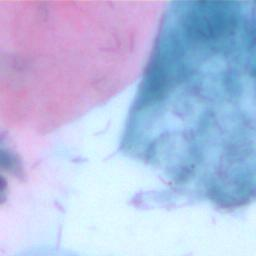

normal: 0.999553382396698


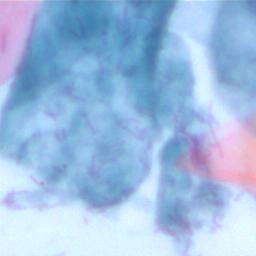

normal: 0.9979512095451355


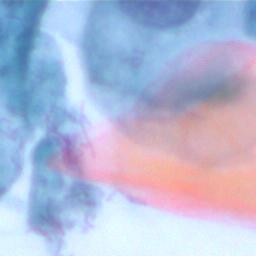

normal: 0.9843189120292664


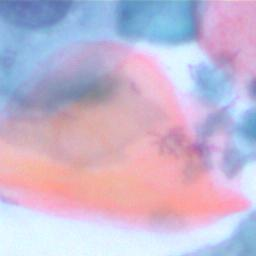

normal: 0.9967431426048279


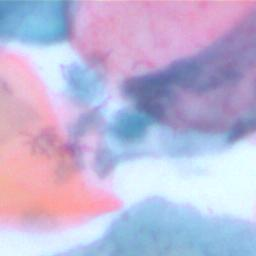

normal: 0.9948293566703796


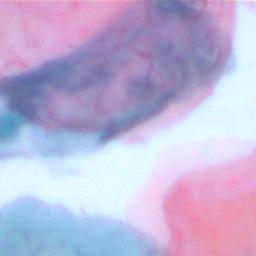

normal: 0.988177478313446


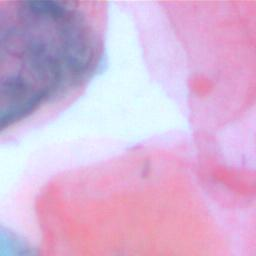

normal: 0.9975513815879822


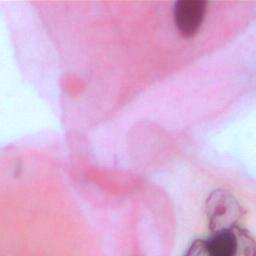

normal: 0.9995154142379761


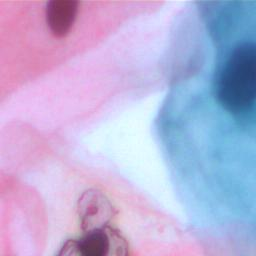

normal: 0.9960148334503174


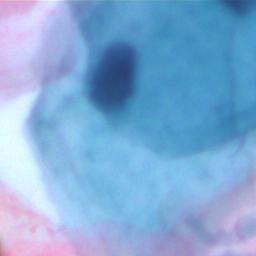

normal: 0.995932400226593


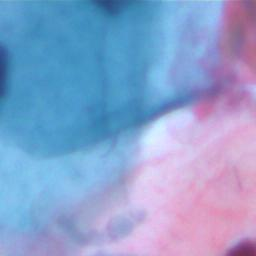

normal: 0.9998559951782227


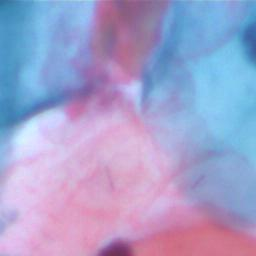

normal: 0.9998960494995117


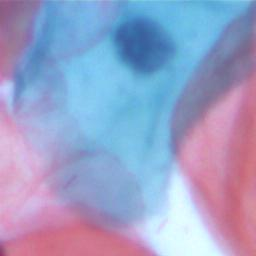

normal: 0.9995293617248535


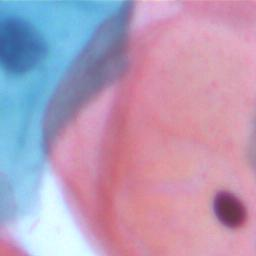

normal: 0.9814623594284058


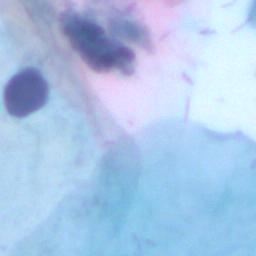

normal: 0.9988080263137817


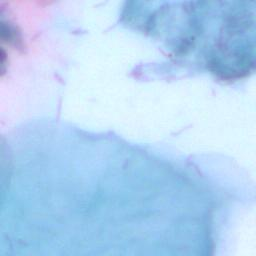

normal: 0.999265730381012


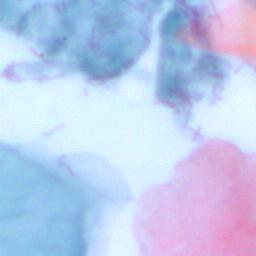

normal: 0.9176560640335083


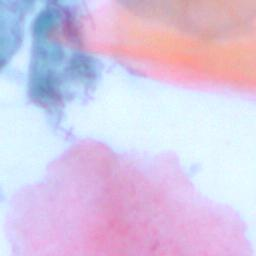

normal: 0.8184328079223633


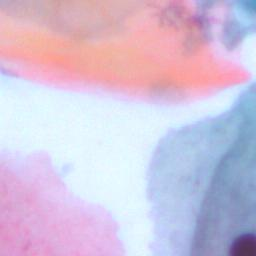

normal: 0.9968733191490173


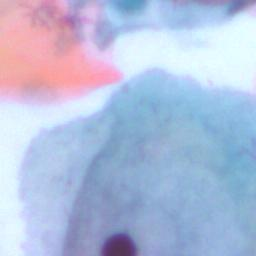

normal: 0.9952619075775146


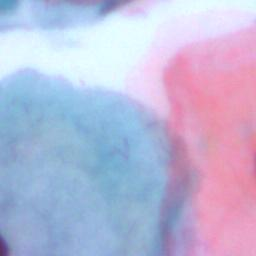

normal: 0.9932742118835449


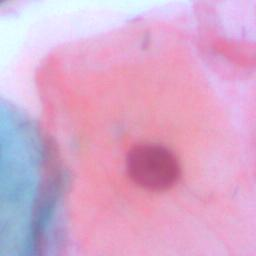

normal: 0.9914551973342896


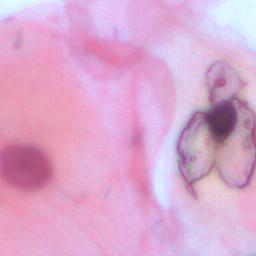

normal: 0.9974186420440674


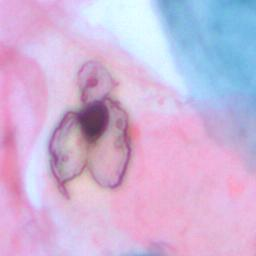

normal: 0.9999886751174927


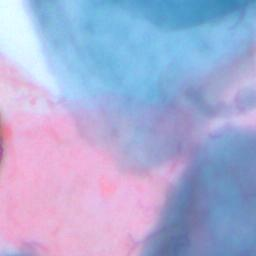

normal: 0.999904990196228


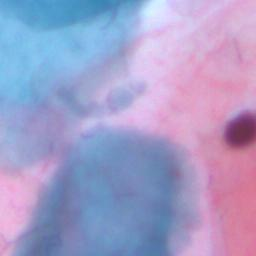

normal: 0.9966275095939636


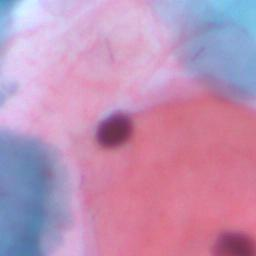

normal: 0.9996140599250793


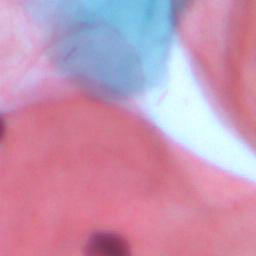

normal: 0.9954890608787537


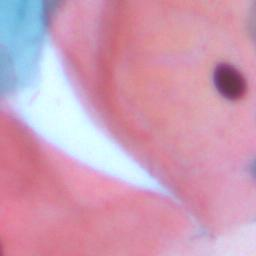

normal: 0.9977571368217468


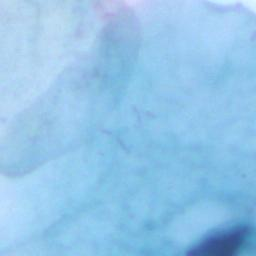

normal: 0.9998629093170166


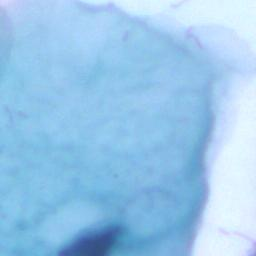

normal: 0.9989614486694336


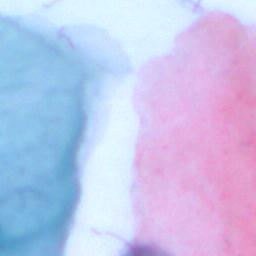

normal: 0.9818392992019653


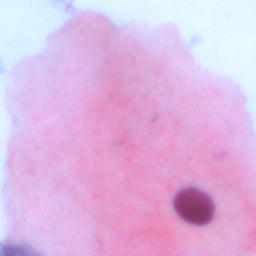

normal: 0.9921162724494934


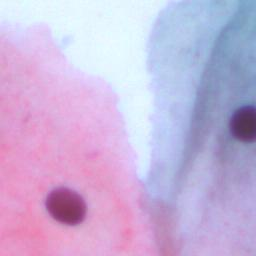

normal: 0.998621940612793


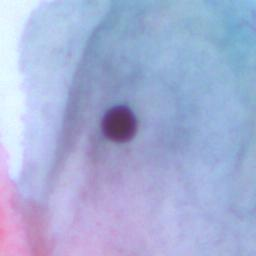

normal: 0.9992062449455261


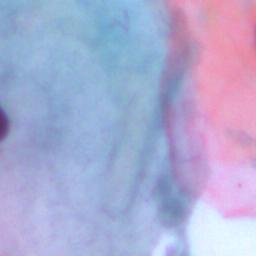

normal: 0.9911323189735413


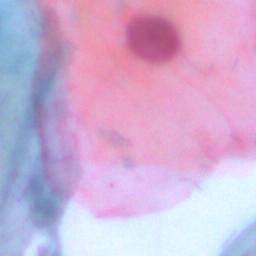

normal: 0.9957678318023682


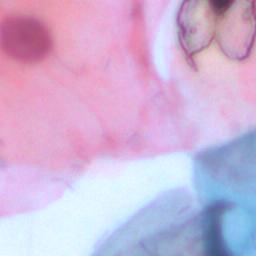

normal: 0.9980844259262085


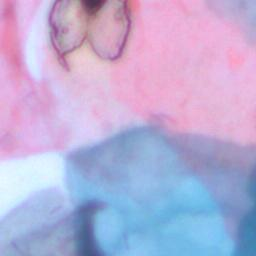

normal: 0.9987460374832153


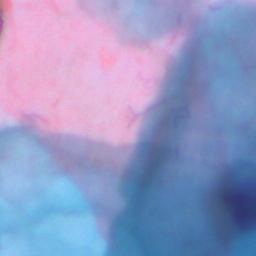

normal: 0.9928315877914429


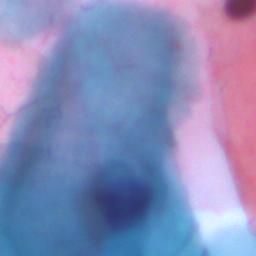

normal: 0.99845290184021


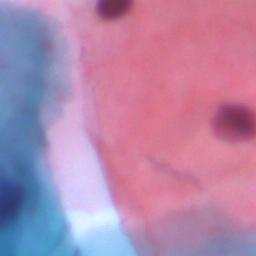

normal: 0.9920011758804321


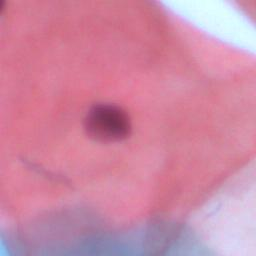

normal: 0.9944663643836975


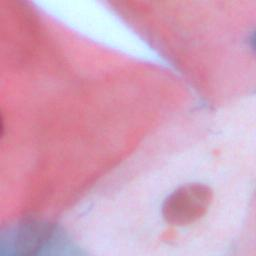

normal: 0.9999650716781616


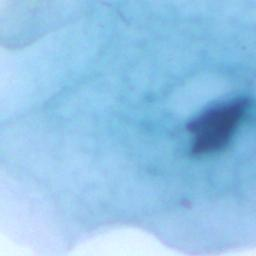

normal: 0.9998094439506531


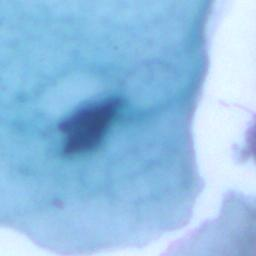

normal: 0.9998010993003845


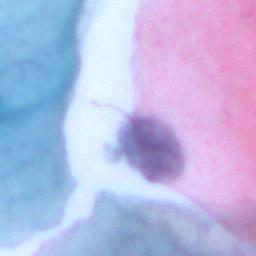

normal: 0.9944478273391724


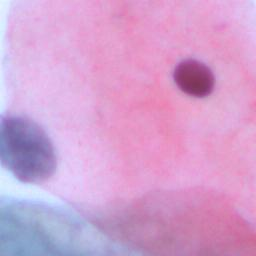

normal: 0.9972015619277954


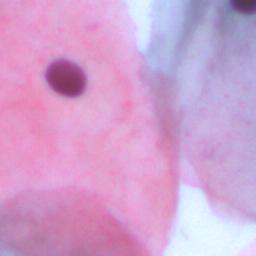

normal: 0.9981651902198792


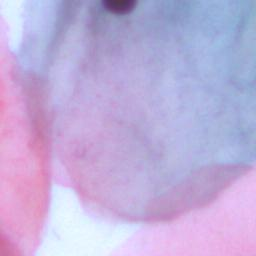

normal: 0.9942604303359985


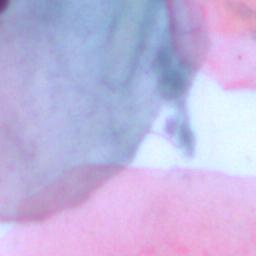

normal: 0.9655292630195618


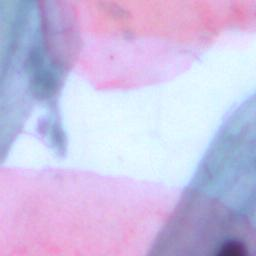

normal: 0.9953943490982056


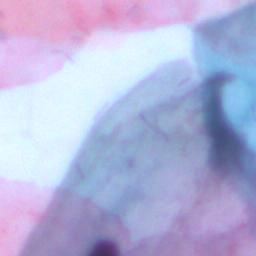

normal: 0.9974467754364014


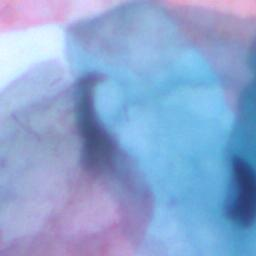

normal: 0.9367038011550903


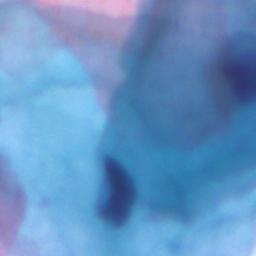

normal: 0.9305968880653381


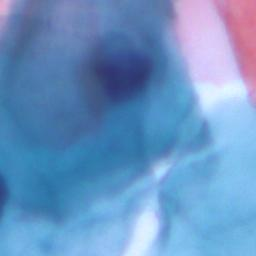

normal: 0.9991827607154846


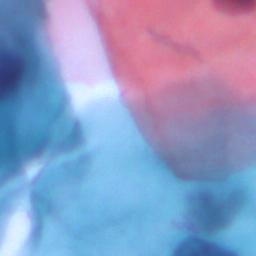

normal: 0.9995797276496887


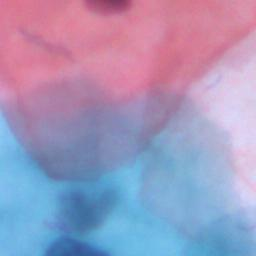

normal: 0.9994938373565674


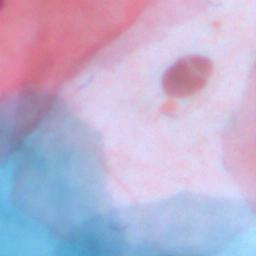

normal: 0.9993566870689392


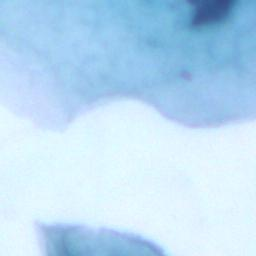

normal: 0.9998090863227844


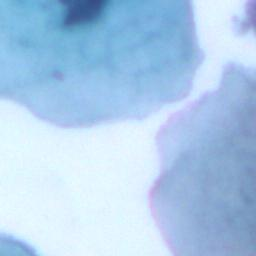

normal: 0.9994426369667053


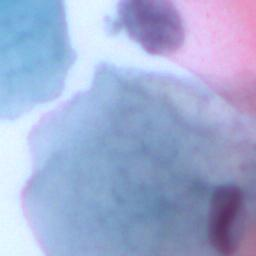

normal: 0.9954198598861694


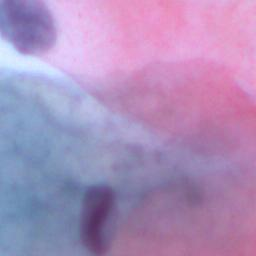

normal: 0.9974892139434814


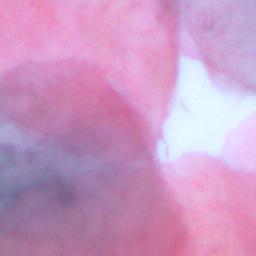

normal: 0.9965065121650696


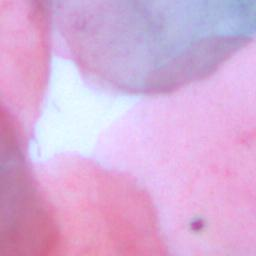

normal: 0.9944374561309814


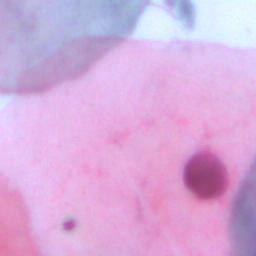

normal: 0.9930649399757385


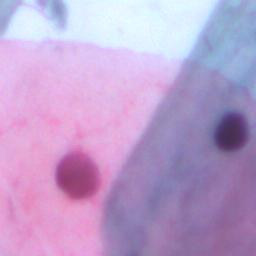

normal: 0.9961680769920349


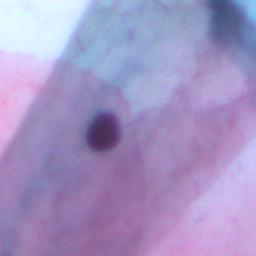

normal: 0.9999798536300659


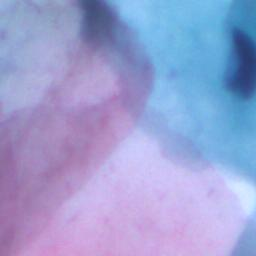

normal: 0.9947840571403503


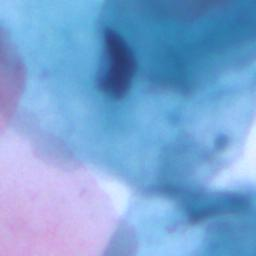

normal: 0.9978491067886353


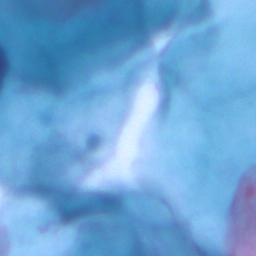

normal: 0.9996374845504761


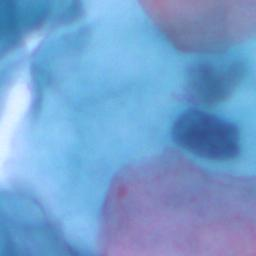

normal: 0.9738543629646301


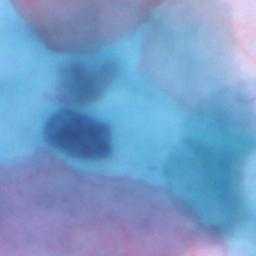

normal: 0.9514358043670654


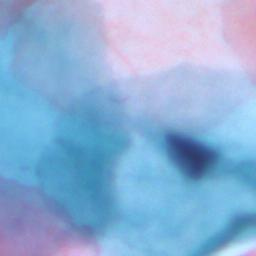

normal: 0.9024370312690735


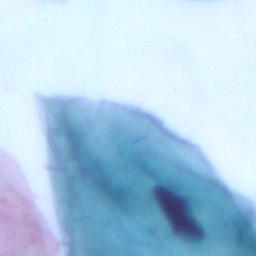

normal: 0.9879850745201111


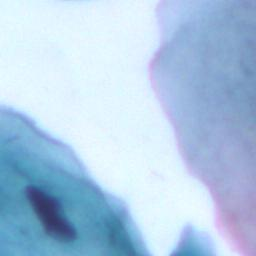

normal: 0.9986211061477661


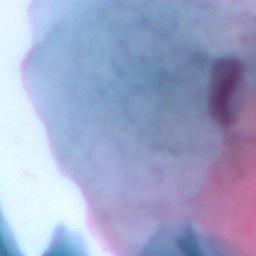

normal: 0.9909823536872864


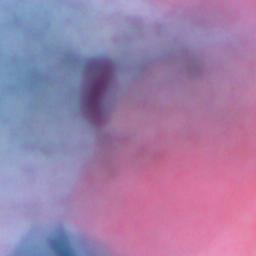

normal: 0.9962577819824219


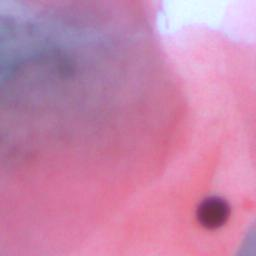

normal: 0.9983336329460144


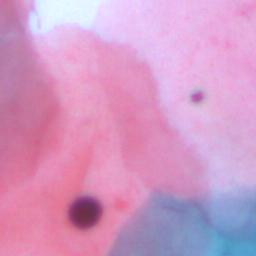

normal: 0.9999285936355591


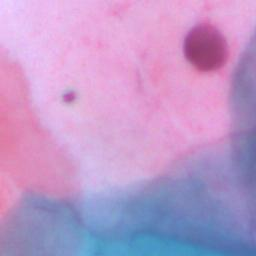

normal: 0.9996531009674072


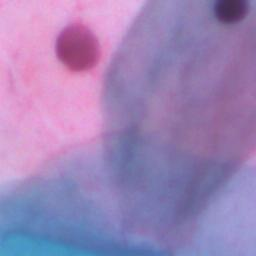

normal: 0.997867226600647


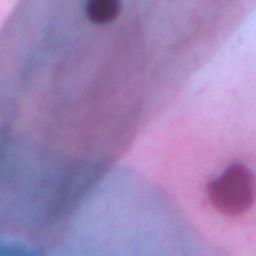

normal: 0.9998779296875


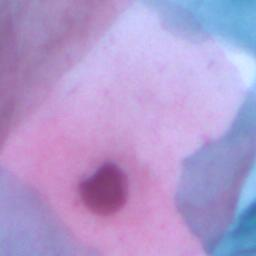

normal: 0.9986333250999451


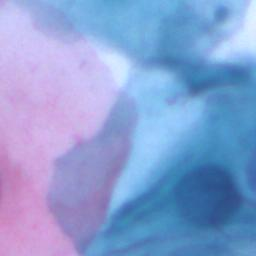

normal: 0.8109275102615356


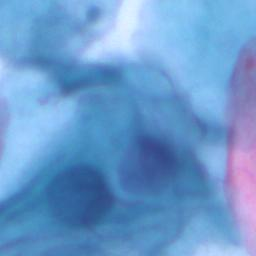

normal: 0.9996726512908936


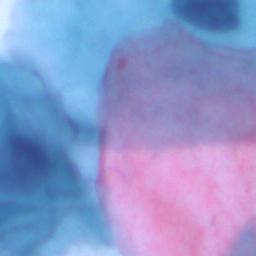

normal: 0.9999144077301025


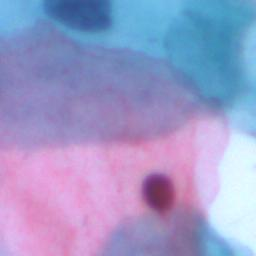

normal: 0.9970865845680237


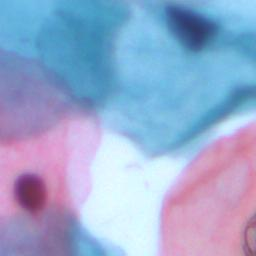

normal: 0.710425615310669


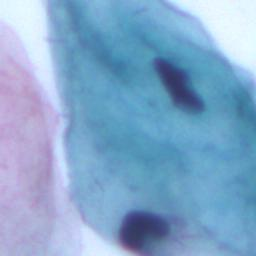

normal: 0.6785825490951538


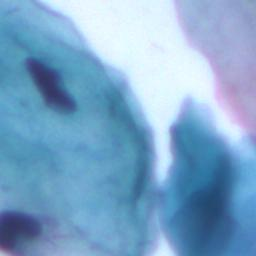

normal: 0.9722174406051636


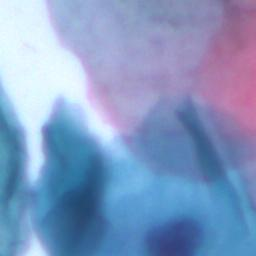

normal: 0.9978600144386292


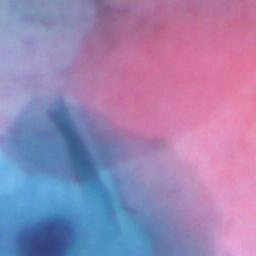

normal: 0.9990668892860413


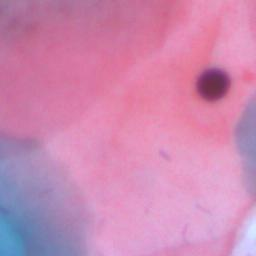

normal: 0.9996304512023926


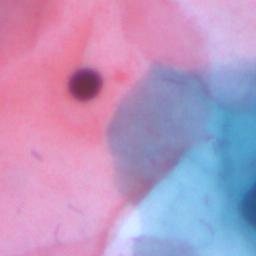

normal: 0.9917587637901306


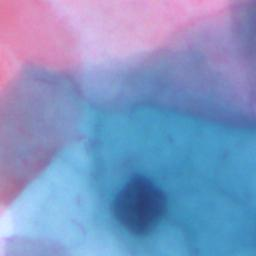

normal: 0.9799842238426208


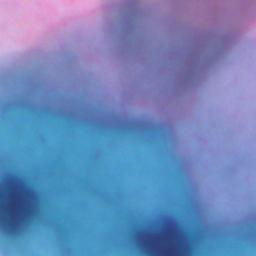

normal: 0.9997755885124207


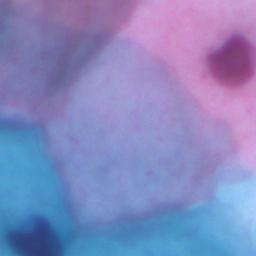

normal: 0.9996240139007568


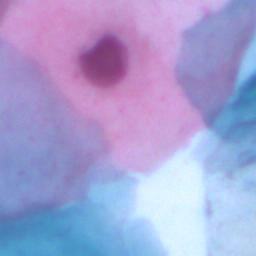

normal: 0.9971215128898621


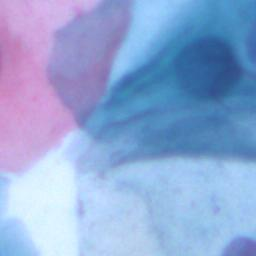

normal: 0.987559974193573


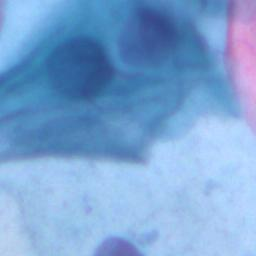

normal: 0.9998795986175537


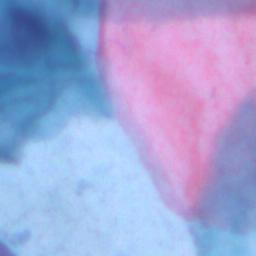

normal: 0.9984194040298462


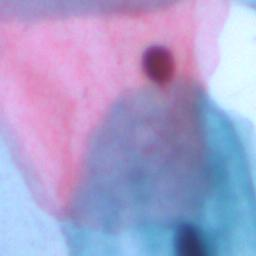

normal: 0.9985017776489258


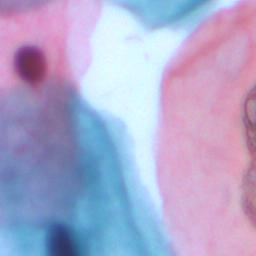

normal: 0.9703336358070374


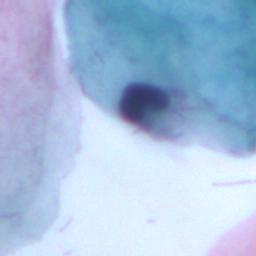

normal: 0.9511471390724182


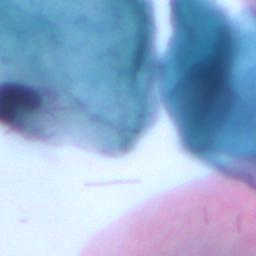

normal: 0.9347474575042725


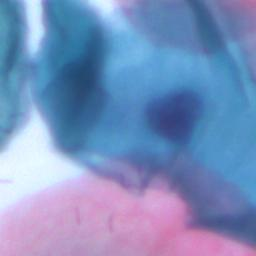

normal: 0.9769218564033508


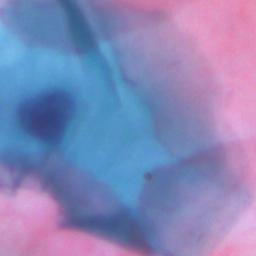

normal: 0.9995380640029907


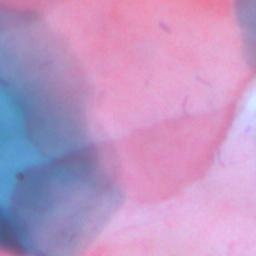

normal: 0.9999184608459473


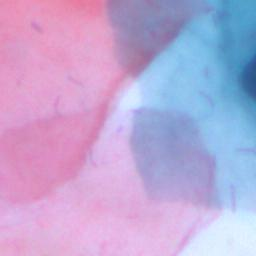

normal: 0.9956169128417969


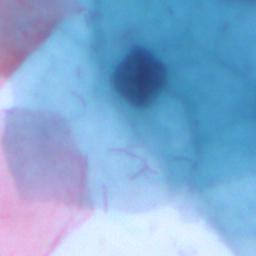

normal: 0.79661625623703


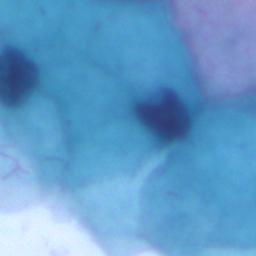

normal: 0.802021861076355


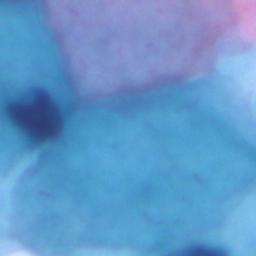

normal: 0.9801545739173889


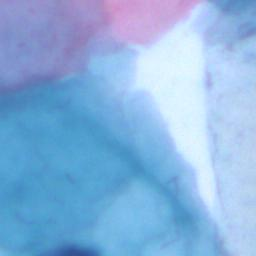

normal: 0.9999104738235474


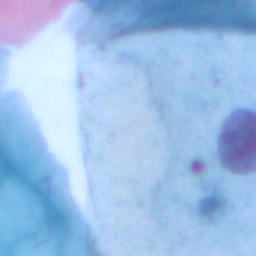

normal: 0.9997974038124084


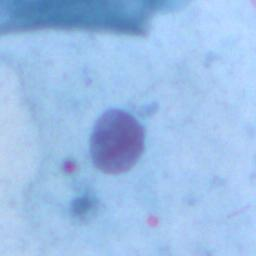

normal: 0.9996448755264282


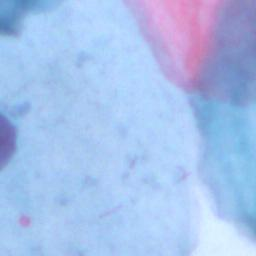

normal: 0.9981939196586609


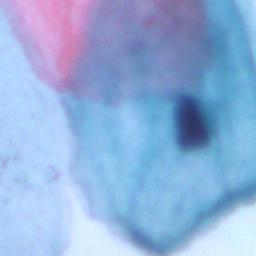

normal: 0.9896711707115173


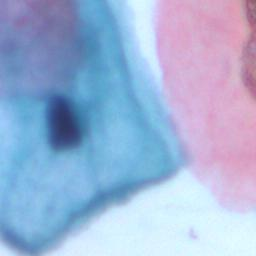

normal: 0.688323974609375


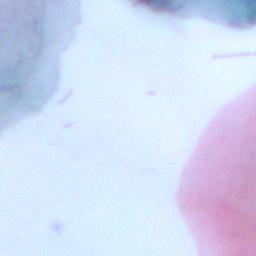

normal: 0.997011661529541


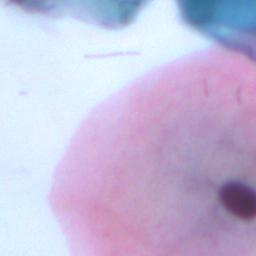

normal: 0.9994538426399231


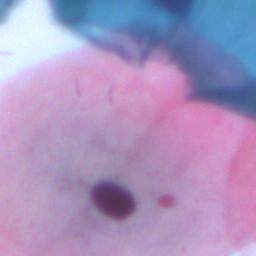

normal: 0.9997871518135071


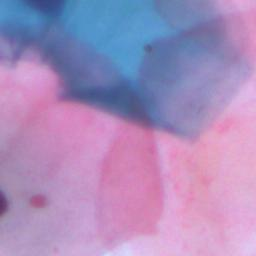

normal: 0.9993718266487122


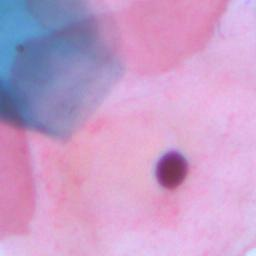

normal: 0.9979031085968018


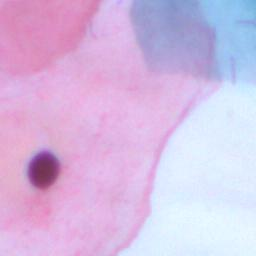

normal: 0.9986444115638733


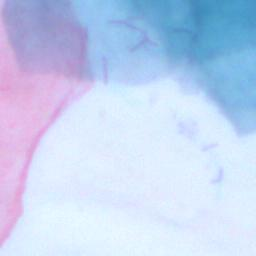

normal: 0.9958940744400024


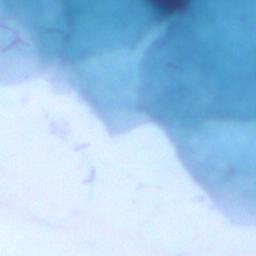

normal: 0.9798368811607361


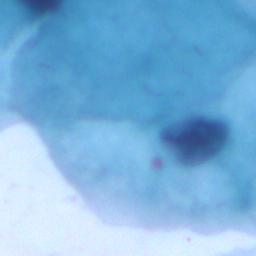

normal: 0.9942104816436768


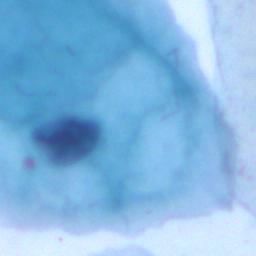

normal: 0.9999029636383057


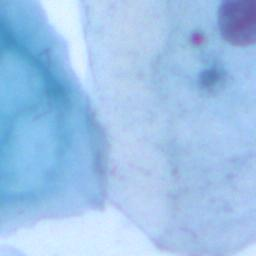

normal: 0.9971194267272949


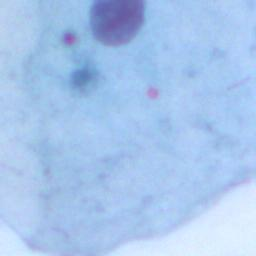

normal: 0.9931542873382568


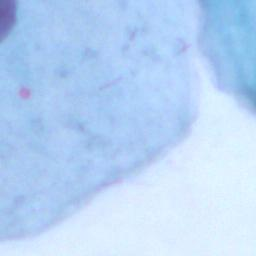

normal: 0.9934846758842468


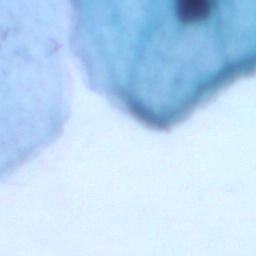

normal: 0.980176568031311


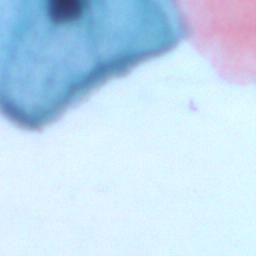

normal: 0.7237632274627686


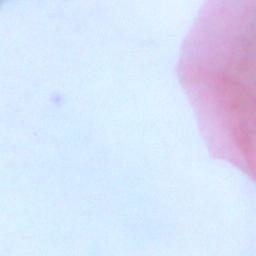

normal: 0.9758952260017395


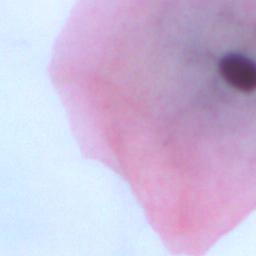

normal: 0.9752538800239563


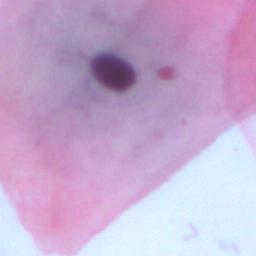

normal: 0.9929978847503662


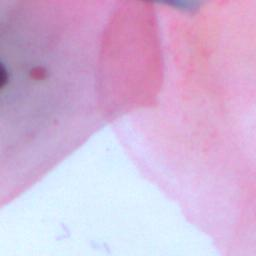

normal: 0.995303750038147


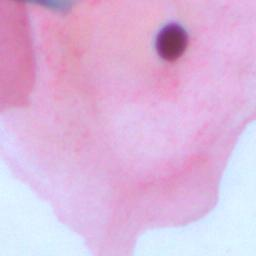

normal: 0.9320814609527588


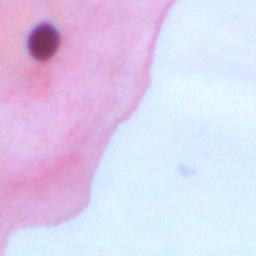

normal: 0.49935752153396606


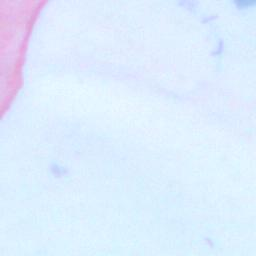

normal: 0.925234317779541


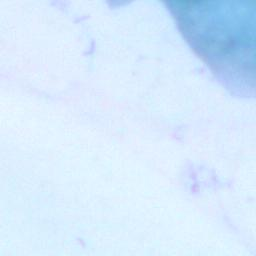

normal: 0.9991408586502075


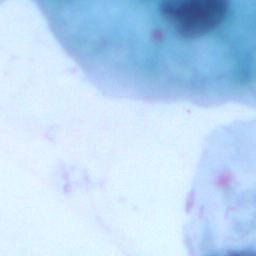

normal: 0.9999539852142334


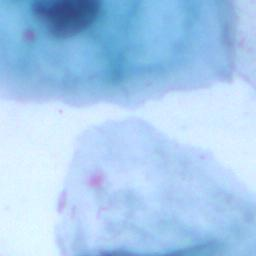

normal: 0.9987030029296875


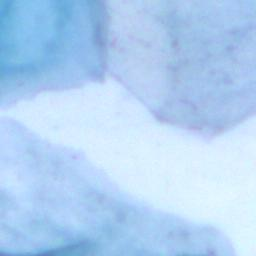

normal: 0.8619788289070129


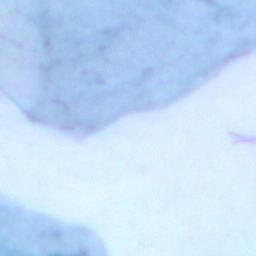

normal: 0.6015498042106628


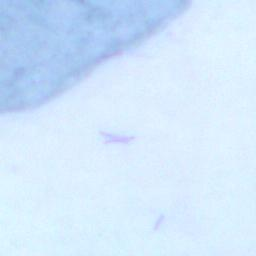

abnormal: 0.5728840827941895


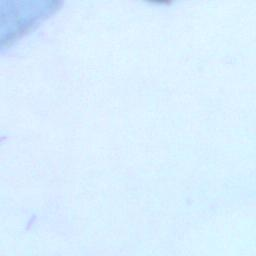

abnormal: 0.5084708333015442


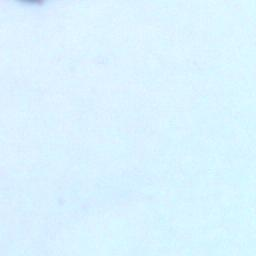

normal: 0.6126143336296082


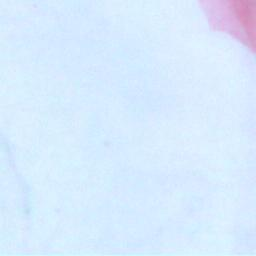

normal: 0.8294128179550171


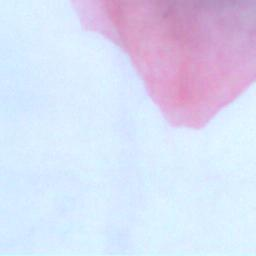

normal: 0.7242282032966614


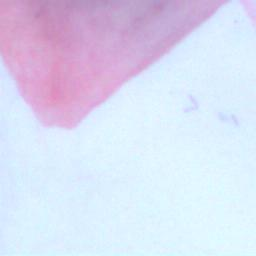

normal: 0.7118929624557495


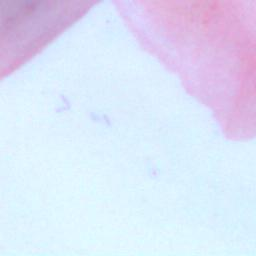

normal: 0.9020888209342957


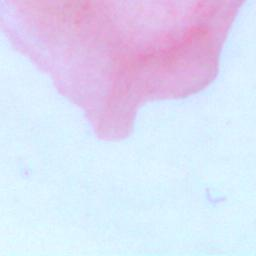

normal: 0.6456051468849182


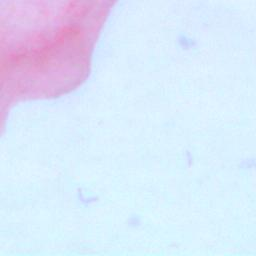

normal: 0.5312375426292419


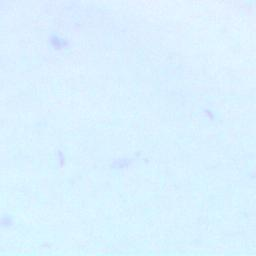

normal: 0.5008655190467834


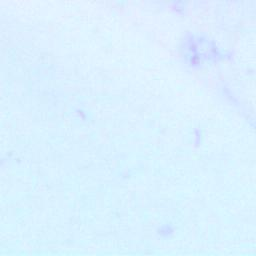

normal: 0.8296823501586914


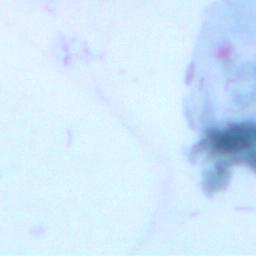

normal: 0.9918609857559204


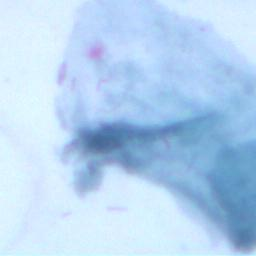

normal: 0.9647268652915955


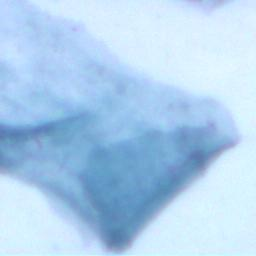

normal: 0.8324337601661682


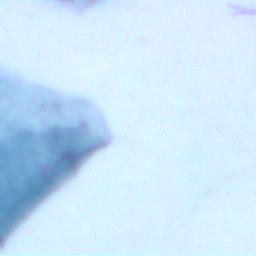

normal: 0.5986782908439636


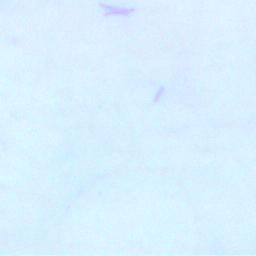

normal: 0.5249578952789307


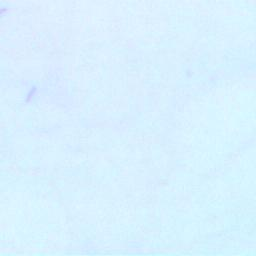

abnormal: 0.5185644030570984


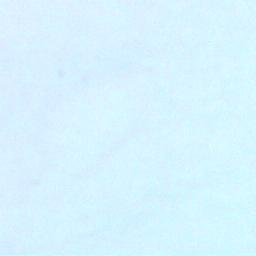

In [36]:
input_size = 224
for i in range(patches.shape[1]):
    for j in range(patches.shape[2]):
        normalize = transforms.Compose([
             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        # print image 
        
        # resize tensor to model input size
        x = F.interpolate(patches[0][i][j], size=224) 
        im = normalize(x)
        out = model(im.unsqueeze(0)).squeeze()
        # get the probability and category of top5 prediction
        prob, categories = out.topk(3)
        # convert the probability to softmax
        sm = torch.nn.Softmax()
        probabilities = sm(prob) 
        
        print(class_name[int(categories[0])] + ": " + str(float(probabilities[0])))
        inp = transp(patches[0][i][j])
        inp = np.array(inp)
        showarray(inp)